# Teste A/B - Pipeline

Esse notebook tem o objetivo de apresentar um passo-a-passo para a criação de testes A/B em um ambiente realista. Utilizaremos o case TeraBuy apresentado em sala de aula. Se tiver interessado em revisar os conceitos de testes de hipótese, [acesse esse notebook](Testes_de_Hipoteses.ipynb).

A [primeira parte](#Parte-1) do notebook contém uma análise exploratória dos dados da empresa TeraBuy. Essa parte é fundamental, pois nos permite entender o comportamento dos nossos clientes. Apenas assim podemos criar hipóteses sólidas para podermos verificar através de testes A/B.

A [segunda parte](#Parte-2) será dividida em dois cases distintos. O primeiro case utilizará um teste A/B para verificar se a mudança de cor do botão da página inicial poderia aumentar a taxa de pessoas que entram na página de produto. O segundo case utilizará um teste A/B no final do funil. Verificaremos se podemos aumentar a nossa taxa de conversão, assim como nosso lucro, ao darmos desconto no frete dos nossos produtos. Esse teste é muito sensível, pois envolve a possibilidade de prejuízo para nossa empresa.

In [1]:
%matplotlib inline
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
# Parte 1
## Análise Exploratória - TeraBuy

![TeraBuy](../imagens/terabuy_controle.png)

---

O nosso principal objetivo como criadores da próxima Amazon do setor de educação (temos que sonhar grande mesmo!) é gerar impacto aos nossos clientes e, consequentemente, gerar lucro. O maior problema das empresas é que elas não conhecem seus clientes, ou pior, elas *acham* que conhecem. Todo cientista precisa ser cético em relação a seus dados e, portanto, precisamos tirar o máximo de informação de nossa população (clientes). Somente quando tivermos confiáveis em relação a essa etapa é que podemos criar e testar hipóteses (testes A/B).

Com a finalidade de aumentarmos nosso conhecimento sobre nossos clientes, suponha que fizemos uma amostragem aleatória dos acessos únicos ao site em um dado período de tempo. Esse arquivo se encontra na pasta `data/exp_clientes.csv`. Esse arquivo contém as seguintes informações:

- **`age`**: Idade dos usuários loggados (não é comum termos essa informação, mas será útil para analisarmos o perfil dos clientes)
- **`start_click`**: Uma flag que indica se o usuário clicou no botão de comprar da página inicial
- **`session_time`**: Tempo que o cliente permaneceu no site (minutos)
- **`converted`**: Uma flag que indica se o usuário finalizou a compra
- **`ticket_price`**: Indica o preço do produto comprado pelo cliente
- **`shipping`**: Preço do frete do equipamento comprado

In [2]:
# Função com algumas estatísticas de sumário úteis
def stats_describe(x):
    print("média:         {:.2f}".format(np.mean(x)))
    print("desvio padrão: {:.2f}".format(np.std(x)))
    print("mínimo:        {:.2f}".format(min(x)))
    print("25% percentil: {:.2f}".format(np.percentile(x, 25)))
    print("50% percentil: {:.2f} (mediana)".format(np.median(x)))
    print("75% percentil: {:.2f}".format(np.percentile(x, 75)))
    print("máximo:        {:.2f}".format(max(x)))
    
    plt.hist(x)
    plt.show()

In [3]:
df = pd.read_csv(filepath_or_buffer='../data/exp_clientes.csv')

df.head(10)

,age,start_click,session_time,converted,ticket_price,shipping
0,37.0,0,11,0,0.000000,0
1,36.0,0,4,0,0.000000,0
2,30.0,1,16,0,0.000000,0
3,35.0,1,16,1,75.521313,22
4,41.0,0,8,0,0.000000,0
5,23.0,1,14,0,0.000000,0
6,35.0,1,6,0,0.000000,0
7,40.0,1,10,0,0.000000,0
8,45.0,1,12,1,91.256230,11
9,38.0,1,8,0,0.000000,0


Quantidade de dados obtidos:

In [4]:
len(df)

20236

Qual é a distribuição de idade dos clientes?

média:         35.02
desvio padrão: 5.00
mínimo:        20.00
25% percentil: 32.00
50% percentil: 35.00 (mediana)
75% percentil: 38.00
máximo:        55.00


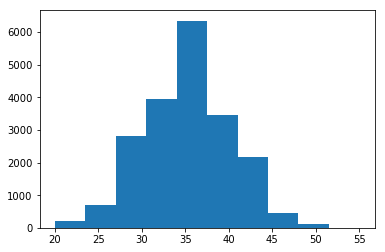

In [5]:
stats_describe(df['age'])

Percebemos que o nosso cliente possui, em média, 35 anos de idade. Não temos outras informações pessoais do nosso cliente, mas poderia ser útil saber qual é o sexo predominante que acessa nosso site, além de outras informações. Esse tipo de informação pode fazer toda a diferença ao criar o plano de negócios da empresa.

*Exemplo: O Elo7 leva muito a sério o perfil dos seus clientes. Nós sabemos, por exemplo, que o perfil mais usual dos nossos clientes é uma mulher de cerca de 35 anos, com um filho e com interesse por produtos infantis e de casamento. Esse perfil nos auxilia em todas as nossas campanhas de marketing e na forma como nos comunicamos com nossos clientes, já que agora sabemos quem ele é.*

Podemos agora tentar achar uma correlação entre cliques e idade média dos usuários.

- Será que há alguma diferença de idade entre as pessoas que clicam ou não no botão da página inicial? Pode ser que isso indique algum comportamento não esperado nos nossos usuários.

Cliente clicou!
---------------
média:         35.01
desvio padrão: 5.00
mínimo:        20.00
25% percentil: 32.00
50% percentil: 35.00 (mediana)
75% percentil: 38.00
máximo:        53.00


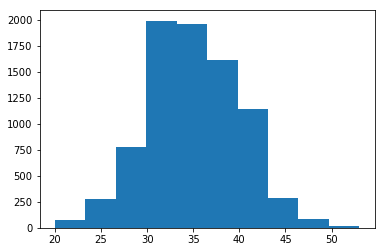

----------------------------------------
Cliente não clicou!
-------------------
média:         35.02
desvio padrão: 5.00
mínimo:        20.00
25% percentil: 32.00
50% percentil: 35.00 (mediana)
75% percentil: 38.00
máximo:        55.00


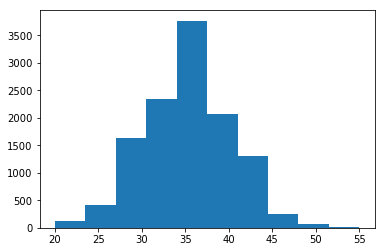

In [6]:
print("Cliente clicou!")
print("---------------")
stats_describe(df[df['start_click']==1]['age'])
print("-"*40)
print("Cliente não clicou!")
print("-------------------")
stats_describe(df[df['start_click']==0]['age'])

Pelo jeito não há diferença. As estatísticas parecem semelhantes.

Agora vem uma pergunta muito importante: 
- Qual é taxa de cliques (CTR) no botão da página inicial?

In [7]:
print("CTR: {:.2%}".format(df['start_click'].mean()))

CTR: 40.68%


- E quanto tempo os clientes permanecem no nosso site?

Essa pergunta é muito útil, porque nos auxilia a entender o comportamento dos nosso usuários com nosso conteúdo.
Por exemplo, a Amazon percebeu que quanto menos tempo uma pessoa passa no site dela, maior a probabilidade de um usuário finalizar uma compra. Por isso, se a empresa deseja aumentar a taxa de conversão, ela poderia simplificar as etapas de compra para tornar o processo mais rápido. Já no Elo7, há um comportamento diferente do nosso usuário. Como nossos produtos são personalizados e únicos, os usuários não sabem exatamente o que estão procurando. Por esse modo, um menor tempo de permanência no site não significa que aumentará a nossa probabilidade de conversão. E no caso da **TeraBuy**? Como será o comportamento do nosso usuário?

média:         8.81
desvio padrão: 3.12
mínimo:        0.00
25% percentil: 7.00
50% percentil: 9.00 (mediana)
75% percentil: 11.00
máximo:        22.00


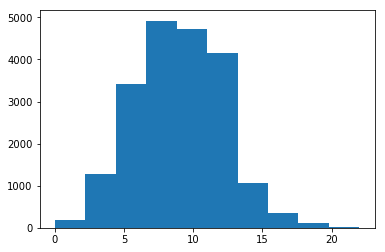

In [8]:
stats_describe(df['session_time'])

- Será que há alguma correlação entre a pessoa clicar no botão "comprar" e o tempo que ela permanece no site?

Cliente clicou!
---------------
média:         9.98
desvio padrão: 3.16
mínimo:        1.00
25% percentil: 8.00
50% percentil: 10.00 (mediana)
75% percentil: 12.00
máximo:        22.00


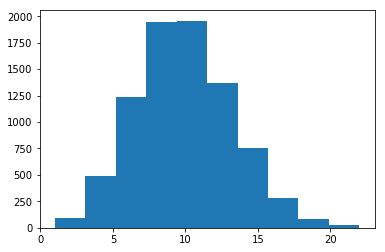

----------------------------------------
Cliente não clicou!
-------------------
média:         8.00
desvio padrão: 2.83
mínimo:        0.00
25% percentil: 6.00
50% percentil: 8.00 (mediana)
75% percentil: 10.00
máximo:        20.00


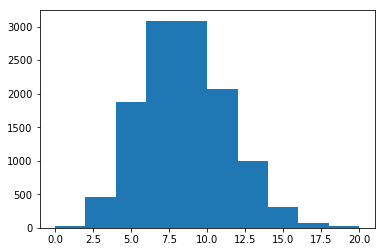

In [9]:
print("Cliente clicou!")
print("---------------")
stats_describe(df[df['start_click']==1]['session_time'])
print("-"*40)
print("Cliente não clicou!")
print("-------------------")
stats_describe(df[df['start_click']==0]['session_time'])

Pelo jeito há alguma correlação. ***Pode*** haver uma relação entre os usuários que clicam no botão inicial e o tempo de permanência no nosso site. Lembre-se sempre que "Correlação não indica causalidade"! Precisariamos de testes mais profundos para criar uma análise de causalidade.

- Qual é a taxa de conversão do nosso e-commerce? Essa é uma boa medida para indicar a saúde financeira do nosso site.

In [10]:
print("Taxa de conversão: {:.2%} (Homepage)".format(df['converted'].mean()))
print("Taxa de conversão: {:.2%} (Página produto)".format(df[df['start_click']==1]['converted'].mean()))

Taxa de conversão: 8.45% (Homepage)
Taxa de conversão: 20.77% (Página produto)


Percebemos que cerca de 8% das pessoas que entram no nosso site (homepage) compram algum produto. E cerca de 20% das pessoas que entram na página de produto convertem. Esses números são bons ou ruins? Você pode tirar essas informações de seu histórico de análises ou informações a respeito de empresas semelhantes a sua. Sempre gostaríamos de otimizar esses números e, portanto, podemos realizar testes A/B para testarmos novas funcionalidades. 

E o nosso frete? Existe um problema comum a todos os e-commerce que entregam produtos via correios que é o preço do frete.

média:         20.01
desvio padrão: 4.95
mínimo:        5.00
25% percentil: 17.00
50% percentil: 20.00 (mediana)
75% percentil: 23.00
máximo:        34.00


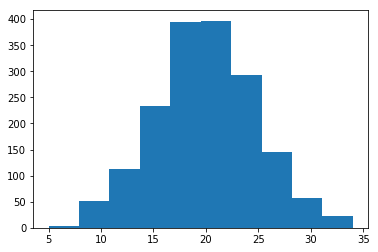

In [11]:
stats_describe(df[df['converted']==1]['shipping']) # Note que temos que considerar apenas os preços de produtos comprados

Até então não sabemos se esses valores são altos ou baixos. Temos a impressão de que isso depende do preço do nosso produto também. Podemos verificar qual é o preço médio pago pelos clientes no nosso site.

média:         100.20
desvio padrão: 21.00
mínimo:        25.74
25% percentil: 85.83
50% percentil: 100.18 (mediana)
75% percentil: 114.96
máximo:        165.17


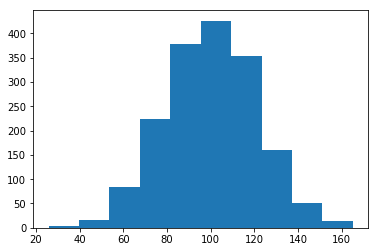

In [12]:
stats_describe(df[df['converted']==1]['ticket_price'])

Em média, nosso cliente paga R\$100,00 por compra (ticket médio). Os valores de frete e ticket médio nos dá um indicativo de comportamento do nosso usuário, mas não nos diz quais são os valores ótimos que deveríamos atingir. As vezes, um valor frete alto aumenta o valor de ticket médio, mas isso não se reflete em lucro, porque apenas quer dizer que o cliente só aceita pagar nosso frete se for para comprar um produto caro. Portanto, esses números sozinhos não são indicativos de saúde financeira da empresa.

Exemplo: Suponha que você seja um cliente da TeraBuy e quisesse comprar um produto de R\$20,00, mas o frete dele é R\$30,00. Você compraria esse produto? E se o seu produto custasse R\$300,00? Provavelmente você não ligaria de pagar os R\$30,00 de frete na segunda opção. Por esse motivo é que um valor de frete alto também aumenta o ticket médio da empresa.

Exemplo 2: Suponha agora que 20 clientes estavam interessados em comprar o primeiro produto do exemplo anterior, mas só um cliente gostaria de comprar o segundo produto. Com o preço do frete, os 20 clientes desistem do primeiro produto e apenas o outro cliente finaliza a compra. Ao final, o ticket médio seria de R\$300,00 e receberíamos esse mesmo valor. Mas, se todos os 21 clientes tivessem comprado, o ticket médio se tornaria aproximadamente R\$33,00 e receberíamos R\$700,00 (sem contar o valor do frete). Portanto, ticket médio e valor do frete são sintomas da saúde financeira da empresa, mas não podem ser analisados sozinhos.


---
# Parte 2
## Case 1 - Teste A/B cor do botão da homepage

Todo teste A/B deve começar com um entendimento claro do problema que devemos atacar. Precisamos entender qual o objetivo que queremos atingir, as hipóteses que queremos testar e definir as métricas que vamos utilizar para verificar o sucesso ou rejeição das nossas hipóteses.

Suponha o seguinte cenário para esse exercício: 
- Ao analisar os dados do TeraBuy, notamos que recebemos um bom tráfego de pessoas na nossa homepage, mas temos uma baixa taxa de pessoas que clicam (CTR: "click-through rate") no botão "compre já!" e, consequentemente, temos uma baixa taxa de conversão (proporção das pessoas que finalizam a compra). Ao levantar as possíveis hipóteses para esse fenômeno, a equipe de front-end sugeriu mudar a cor do botão, porque, segundo eles, isso melhoraria a visibilidade do texto. Mas, como cético que você é, você cria a sua hipótese inicial: "Será que a mudança da cor do botão mudaria o comportamento dos usuários?". Vamos realizar um teste A/B!

Página do experimento:
![TeraBuy](../imagens/terabuy_experimento.png)

Agora podemos definir claramente nossos objetivos, hipóteses e métricas:

- **Objetivo**: Melhorar a taxa de cliques no botão "compre já" na homepage do site TeraBuy.

- **Hipótese**: A mudança de cor do botão "compre já" aumentará a taxa de pessoas que clicam no botão

- **Métricas**: Taxa de cliques no botão (CTR)
(Pergunta: Por que não utilizar a taxa de conversão como métrica?)

*Obs: Note que a hipótese inicial do problema não necessariamente será a hipótese nula/alternativa do nosso teste de hipóteses. Muitas vezes essa hipótese inicial implica em diversas outras, que chamamos de "hipóteses implícitas". Utilizando o exemplo do teste A/B atual, nós estamos utilizando uma hipótese genérica, porque ela não isola possíveis variáveis do problema, como a idade do cliente ou o dia da semana. Nesse caso, uma hipótese implícita poderia ser "Não há diferença entre a taxa de cliques no botão em função da idade do cliente" ou "Não há variação entre a taxa de cliques no botão inicial em função do dia da semana". Um bom teste A/B tentaria isolar todas essas variáveis e hipóteses implícitas para ter uma visão global do problema. Mas, vamos utilizar uma simplificação do problema nesse case.

Detalhes técnicos (ir)relevantes: Cada usuário que entra no site recebe um identificador único, que é chamado de "cookie", e está associado ao seu ip. Dessa forma, podemos acompanhar o comportamento do cliente no site durante sua sessão. Quando realizamos um teste A/B, nós associamos aleatoriamente um dado cookie a um determinado "bucket" ("A" ou "B"). O cookie associado ao bucket "A" não perceberá qualquer variação no site, enquanto o cookie associado ao bucket "B" visualizará o conteúdo de teste. Todos os cookies associados ao bucket "A" entram no que chamamos de "grupo de controle", enquanto os outros estarão no "grupo de experimento".

---
#### Etapa 1: Modelagem do teste A/B

Antes de começarmos o nosso teste A/B, nós precisamos definir claramente os parâmetros que serão utilizados. Na maioria das vezes, os testes A/B começam sem termos definido os objetivos queremos atingir e em qual prazo. Esse é o pior erro que pode ser feito ao realizarmos um experimento estatístico. Precisamos entender claramente nosso teste e saber o que queremos medir. Mais especificamente, precisamos definir os 5 parâmetros essenciais: número de direções do teste, nível de significância, poder estatístico, tamanho da amostra e efeito mínimo.

- **Número de direções do teste ($d$):** Vamos utilizar um teste bilateral, ou seja, $d$=2. Desse modo, poderemos perceber variações positivas e negativas, se houver. Também seremos mais exigentes para rejeitar uma hipótese para cada lado (lembre-se que nos testes bilaterais nós dividimos o nível de significância em 2).

- **Nível de significância ($\alpha$):** Ao escolhermos um nível de significância, nós estamos definindo a nossa taxa de erros tipo 1, ou seja, a nossa probabilidade de obtermos falsos positivos. Nós não precisamos de um nível de significância tão rígido nesse teste em específico, mas temos que entender quais são nossos riscos. Lembre-se que sempre há custos envolvidos ao modificarmos uma nova funcionalidade e não queremos gerar custos desnecessários. Dada essa análise preliminar, vamos escolher um $\alpha$ = 5%.

- **Poder estatístico ($1-\beta$):** O poder do teste mede a nossa capacidade de medirmos uma variação (efeito mínimo), caso ela exista. Em outras palavras, ele indica o oposto da taxa de erros tipo 2, ou seja, a probabilidade de obtermos falsos negativos. Nós temos sempre o objetivo de observar variações existentes, mesmo que pequenas, mas isso significa aumentarmos nossa amostra e, por consequência, aumentarmos o tempo de duração e custo do nosso teste. Vamos utilizar nesse case um valor de $1-\beta$=80%. Na prática, isso significa que estamos com uma postura um pouco mais conservadora em relação ao teste. Menor valor do poder significa que diminuímos nossa probabilidade de rejeitarmos a hipótese nula.

- **Efeito mínimo ($e$)**: O efeito mínimo que queremos observar é um parâmetro essencial para definirmos qual é a métrica de sucesso do nosso teste de hipótese. Na prática, ele significa o menor valor de variação que gostaríamos de perceber para valer a pena aceitarmos a hipótese. Ele é definido com base na experiência do analista do teste A/B ou do responsável por tomar a decisão na empresa. No nosso caso, nós fizemos uma reunião e definimos que o teste só valerá a pena se o efeito mínimo observado será de $e$=2%.

- **Tamanho da amostra (N):** O tamanho da amostra é uma consequência dos parâmetros anteriores. Ele define o tempo que precisaremos realizar o teste e, por consequência, qual será nosso custo com o teste. Na maioria dos testes nós vamos fixar os 4 parâmetros anteriores e calcular o tamanho mínimo de amostra que precisaríamos para obtermos um teste com essas características.


In [13]:
# Parâmetros do teste A/B
d = 2            # direções
alpha = 0.05     # nível de significância
beta = 0.2       # taxa de erros tipo 2
power = 1-beta   # poder estatístico
e = 0.02         # efeito mínimo

Agora precisamos calcular o tamanho mínimo de amostra para cada "bucket". Lembre-se que esse tamanho é a quantidade de pessoas que entram em cada um dos exemplos (bucket A ou B) e não o número de sucessos.

Poderíamos utilizar uma calculadora ([link](http://www.evanmiller.org/ab-testing/sample-size.html)) ou utilizar a seguinte função:

In [14]:
# Algoritmo para cálculo do mínimo tamanho de amostra.
# Mesmo algoritmo utilizado em http://www.evanmiller.org/ab-testing/sample-size.html
def calc_min_sample_size(alpha=0.05, beta=0.2, tails=2, base_prop=0.5, min_effect=0.1):
    sig1 = np.sqrt(2*base_prop*(1-base_prop))
    sig2 = np.sqrt(base_prop*(1-base_prop)+(base_prop+min_effect)*(1-base_prop-min_effect))
    sample_size = ((st.norm.ppf(1-alpha/tails)*sig1 + st.norm.ppf(1-beta)*sig2)/min_effect)**2
    return int(sample_size)

Esse algoritmo tem como entrada todos os 4 parâmetros apresentados anteriormente e também a variável `base_prop`, que é a taxa padrão de sucesso (CTR) sem aplicar o teste A/B. Sabemos pela análise exploratória da [Parte 1](#Parte-1) que essa taxa é de, aproximadamente, 40%.

In [15]:
n_min = calc_min_sample_size(alpha=alpha, beta=beta, tails=d, base_prop=0.4, min_effect=e)

print("Mínimo tamanho de amostra (por bucket): {}".format(n_min))

Mínimo tamanho de amostra (por bucket): 9439


Portanto, precisamos de cerca de 9500 usuários, no mínimo, em cada bucket para realizarmos o experimento com as características definidas anteriormente.

#### Etapa 2: Geração de dados do teste

Temos agora todas as ferramentas para poder gerar os dados do nosso teste. Lembre-se de que precisamos definir algumas regras para gerar uma amostra representativa da nossa população de interesse. Primeiramente, precisamos garantir que os buckets devem ser preenchidos de maneira aleatória. Depois, precisamos definir qual é a proporção de pessoas que entrarão em cada bucket. Algumas vezes não gostaríamos de ter 50% dos usuários no bucket B (bucket de experimento), porque pode ser uma funcionalidade nociva para a empresa. Nesse caso, acreditamos que não há problema me deixar os dois buckets com a mesma quantidade de usuários, portanto os usuários possuem a mesma probabilidade (50%) de ver o botão antigo e o novo. Por último, precisamos garantir que não haja interferência de outras variáveis durante nosso teste A/B. As vezes o comportamento do nosso usuário é diferente em feriados ou datas festivas. Portanto, devemos tomar cuidado ao realizarmos um teste nessas datas.

Para simularmos a geração de dados para nosso teste, foi desenvolvido um módulo chamado `gen_ab_test_data`. A classe que utilizaremos é a `ColorABTest` e ela contém o dataframe com os dados do teste A/B realizado. Diferentemente do dataframe utilizado anteriormente na análise exploratória, esse dataframe contém uma coluna chamada "bucket", que indica se o usuário viu ou não a nova funcionalidade. Ou seja, se bucket=1, o usuário viu o botão vermelho.

---
*Obs: O dataset a ser utilizado para o teste A/B é gerado com valores aleatórios, mas com a distribuição e parâmetros reais aos encontrados em testes A/B realizados anteriormente para outros fins (top secret!). Note que o fato de ser aleatório nos permite verificar que cada repetição do teste A/B realizado pode nos dar resultados diferentes. É exatamente essa incerteza que nós estamos interessados em mensurar. Quanto mais vezes repetirmos nosso teste A/B, menores são nossas chances de cometermos erros tipo 1 e 2. Mas, nem sempre temos tempo e dinheiro para fazer isso.*

*Obs 2: Nunca utilize os mesmos dados utilizados para análise exploratória para fazer testes de hipóteses. O objetivo da análise exploratória é para gerar insights e hipóteses iniciais do problema em questão. Se você testar as hipóteses criadas com esses mesmos dados, você encontrará resultados enviesados que podem não refletir a realidade.*

---

Vamos agora gerar os dados do teste. Suponha que nós temos cerca de 5000 usuários únicos no nosso site por semana. Como precisamos de, no mínimo, 9500 usuários por bucket e temos uma divisão de 50%-50% entre os buckets A e B, precisaríamos realizar o teste por 4 semanas, completando aproximadamente 10000 usuários por bucket.

In [16]:
import gen_ab_test_data

# Gera um objeto da classe do teste A/B de cores do botão "compre já"
teste_ab = gen_ab_test_data.ColorABTest(n_data=10000)

# Para acessar o dataframe do teste, acesse o atributo "df"
teste_ab.df.head(10)

,bucket,age,start_click,session_time,converted,ticket_price,shipping
0,1.0,32.0,0,6,0,0.000000,0
1,0.0,35.0,1,11,1,110.091056,16
2,0.0,26.0,0,4,0,0.000000,0
3,1.0,28.0,1,6,0,0.000000,0
4,0.0,42.0,0,5,0,0.000000,0
5,1.0,35.0,0,8,0,0.000000,0
6,0.0,34.0,0,13,0,0.000000,0
7,0.0,30.0,0,10,0,0.000000,0
8,1.0,43.0,1,9,0,0.000000,0
9,0.0,34.0,1,7,1,93.170059,23


Na classe `ColorABTest` do módulo `gen_ab_test_data` existem alguns métodos que auxiliam a geração de algumas estatísticas úteis para nosso problema. As funções existentes são:

In [17]:
# Para encontrar o valor médio de uma coluna para um determinado valor de bucket, você pode utilizar o método "mean_bucket"
print("Média: {:.2f}".format(teste_ab.mean_bucket(bucket=0, field='age')))

# O mesmo se aplica para o desvio padrão com o método "std_bucket"
print("Desvio padrão: {:.2f}".format(teste_ab.std_bucket(bucket=0, field='age')))

# Encontrar a taxa de cliques (CTR) do botão inicial para o bucket A (bucket=0)
print("CTR: {:.2%}".format(teste_ab.ctr_bucket(bucket=0)))

# Encontrar a taxa de conversão do site para o bucket A (bucket=0) (de todas as pessoas que entraram no site)
print("Taxa Conversão (Absoluta): {:.2%}".format(teste_ab.conv_rate_abs_bucket(bucket=0)))

# Encontrar a taxa de conversão do site para o bucket A (bucket=0) (apenas pessoas que estão na página de produto)
print("Taxa Conversão (Relativa): {:.2%}".format(teste_ab.conv_rate_rel_bucket(bucket=0)))

Média: 35.00
Desvio padrão: 5.01
CTR: 40.15%
Taxa Conversão (Absoluta): 8.19%
Taxa Conversão (Relativa): 20.39%


---
#### Etapa 3: Teste de hipóteses

Agora vamos começar a etapa de criação do nosso teste de hipóteses. O objetivo do nosso teste A/B é o de medir a variação entre duas proporções de sucesso (cliques no botão) entre duas populações diferentes (bucket "A": $p_A$ e bucket "B": $p_B$). Definiremos a hipótese nula indicando que os dois buckets são idênticos. Alternativamente, a hipótese alternativa indica uma variação estatisticamente significativa entre as proporções dos buckets.

$$H_0: p_B - p_A = 0$$
$$H_1: p_B - p_A \neq 0$$

Simplificações:
- assumiremos que cada evento associado ao sucesso ou não do clique é independente dos demais.
- assumiremos que as duas proporções possuem variância semelhante.
- modelaremos a proporção de cliques como uma distribuição binomial

A partir dessas simplificações, podemos iniciar os cálculos para nosso teste!

Vamos iniciar calculando as proporções:

In [18]:
ctr_0 = teste_ab.ctr_bucket(bucket=0)
ctr_1 = teste_ab.ctr_bucket(bucket=1)

print('CTR_0: {:.2%}'.format(ctr_0))
print('CTR_1: {:.2%}'.format(ctr_1))

CTR_0: 40.15%
CTR_1: 44.57%


Podemos perceber que há uma variação de taxa de cliques para os dois buckets. Mas, essa diferença poderia ter sido gerado por simples acaso? Vamos medir a probabilidade desse acontecimento a seguir.

Podemos também medir as taxas de conversão para cada bucket:

In [19]:
conv_rate_0 = teste_ab.conv_rate_abs_bucket(bucket=0)
conv_rate_1 = teste_ab.conv_rate_abs_bucket(bucket=1)

print('Conversion_rate_0: {:.2%}'.format(conv_rate_0))
print('Conversion_rate_1: {:.2%}'.format(conv_rate_1))

Conversion_rate_0: 8.19%
Conversion_rate_1: 8.84%


Também há uma variação de taxa de conversão entre os dois. Pode ser um bom sinal!

Agora vamos iniciar os cálculos para verificar se a diferença entre os buckets é estatisticamente significativa.

Para esse teste, utilizaremos o teste Z agrupado para diferentes populações ([link](https://www.youtube.com/watch?v=hWYWHuH_zIw)). Poderíamos escolher diversos outros tipos de testes estatísticos, como o [Qui-Quadrado](https://pt.wikipedia.org/wiki/Qui-quadrado), [teste T](https://pt.wikipedia.org/wiki/Teste_t_de_Student), entre outros. O teste Z agrupado é um teste útil quando queremos medir variações entre proporções de sucesso entre amostras semelhantes (mesma variância).

---
##### Teste Z agrupado:
Supondo que as duas populações possuem mesma proporção (hipótese nula), podemos calcular a **proporção agrupada** por:
$$\overline{p} = \frac{s_A + s_B}{N_A + N_B}$$
onde $s_X$ indica o número de sucessos do bucket X e $N_X$ é o numero total de usuários no bucket X. A proporção de sucesso de um bucket qualquer é calculado por: 
$$\hat{p}_X = \frac{s_X}{N_X}$$
(Note que o símbolo ^ indica que a proporção foi calculada empiricamente, ou seja, é apenas uma estimativa da proporção real da população obtida a partir da nossa amostra)

O desvio padrão pode ser estimado utilizando a mesma hipótese, onde obtém-se o **desvio padrão agrupado**:
$${se}(\hat{p}_B - \hat{p}_A) = \sqrt{\overline{p} (1-\overline{p}) (\frac{1}{N_A} + \frac{1}{N_B})}$$

Agora podemos calcular o ["z-score"](https://en.wikipedia.org/wiki/Standard_score) do teste, considerando que temos um tamanho de amostra suficientemente grande para aproximarmos a distribuição por uma normal.
$$Z = \frac{\hat{p}_B - \hat{p}_A}{{se}(\hat{p}_B - \hat{p}_A)}$$

Podemos também calcular o "z-score" para o nível de significância $\alpha$. Como utilizamos o teste bilateral, utilizaremos, na verdade, o z-score de $\frac{\alpha}{2}$. Esse valor pode ser calculado a partir de um software ou por uma tabela ([link](http://www.stat.ufl.edu/~athienit/Tables/Ztable.pdf)) (Por exemplo, para um $\frac{\alpha}{2}$=0.025, temos um z-score de 1.96)

Finalmente, o intervalo de confiança do nosso teste será:
$${I.C.} = \hat{p}_B - \hat{p}_A \pm Z_\frac{\alpha}{2} * {se}(\hat{p}_B - \hat{p}_A)$$

Vamos agora calcular os valores do teste Z:

In [20]:
# Número de sucessos
s_A = len(teste_ab.df[(teste_ab.df['bucket']==0) & (teste_ab.df['start_click']==1)])
s_B = len(teste_ab.df[(teste_ab.df['bucket']==1) & (teste_ab.df['start_click']==1)])

# Tamanho efetivo da amostra
N_A = len(teste_ab.df[teste_ab.df['bucket']==0])
N_B = len(teste_ab.df[teste_ab.df['bucket']==1])

# Proporção de sucesso (CTR)
p_A = s_A/N_A # = ctr_0
p_B = s_B/N_B # = ctr_1

print("Número de sucessos (bucket A): {}".format(s_A))
print("Número de sucessos (bucket B): {}".format(s_B))
print("-"*30)
print("Tamanho da amostra (bucket A): {}".format(N_A))
print("Tamanho da amostra (bucket B): {}".format(N_B))
print("-"*30)
print("Proporção de sucesso (bucket A): {:.2%}".format(p_A))
print("Proporção de sucesso (bucket B): {:.2%}".format(p_B))
print("-"*30)

Número de sucessos (bucket A): 3978
Número de sucessos (bucket B): 4405
------------------------------
Tamanho da amostra (bucket A): 9907
Tamanho da amostra (bucket B): 9884
------------------------------
Proporção de sucesso (bucket A): 40.15%
Proporção de sucesso (bucket B): 44.57%
------------------------------


Vamos criar uma função para automatizar a geração do p-valor e intervalo de confiança

In [21]:
def calc_ab_test(N_A=None, N_B=None, s_A=None, s_B=None, alpha=0.05, power=0.8, tails=2, min_effect=None):
    # calcule a proporção agrupada do teste A/B
    p_pool = (s_A + s_B)/(N_A + N_B)

    # calcule o erro padrão agrupado
    se_pool = np.sqrt(p_pool*(1-p_pool)*(1/N_A+1/N_B))

    # calcule o z-score do teste
    p_diff = s_B/N_B - s_A/N_A
    z_test = (p_diff)/se_pool

    # Calcular z_alpha/2
    # Utilizaremos a função do scipy para cálculo do "percent point function",
    # também chamada de "quantile function". Indica o valor do z-score que 
    # nos daria uma probabilidade menor ou igual a alpha/tails
    z_alpha2 = st.norm.ppf(1-alpha/tails)
    
    # Intervalo de confiança
    ic_min = p_diff - z_alpha2*se_pool
    ic_max = p_diff + z_alpha2*se_pool
    ic = [ic_min, ic_max]
    
    # Calcular o p-valor
    # Usamos a função "survival function" do scipy para calcular
    # qual é a probabilidade de obtermos uma medida tão extrema
    # quanto a observada (z-test) 
    p_value = st.norm.sf(z_test)
    
    return p_value, ic

#### Etapa 4: Análise dos resultados

Vamos analisar os dados do teste A/B!

In [22]:
# Teste A/B:
p_value, ic = calc_ab_test(N_A, N_B, s_A, s_B, alpha, power, tails=d, min_effect=e)

ic_min, ic_max = ic

print("Resultados do teste A/B:")
print("------------------------")
print("- Observamos uma variação entre [{:.2%}, {:.2%}]".format(ic_min, ic_max))
print("- p-valor = {:.4%}".format(p_value))

print("\nVeredito:")
# veredito:
if p_value < alpha/d:
    print('- {:.4%} < {:.4%}: Teste estatisticamente significativo! =)'.format(p_value, alpha/d))
    if ic_min > e:
        print('- {:.4%} > {:.4%}: Teste significativo na prática! =)))'.format(ic_min, e))
    else:
        print('- {:.4%} < {:.4%}: Efeito mínimo não alcançado. O que fazer? =|'.format(ic_min, e))
else:
    print('- {:.4%} > {:.4%}: Teste não é estatisticamente significativo! =('.format(p_value, alpha/d))

Resultados do teste A/B:
------------------------
- Observamos uma variação entre [3.04%, 5.79%]
- p-valor = 0.0000%

Veredito:
- 0.0000% < 2.5000%: Teste estatisticamente significativo! =)
- 3.0367% > 2.0000%: Teste significativo na prática! =)))


Nosso teste é estatisticamente significativo e superior ao efeito mínimo desejado! Podemos então rejeitar a hipótese nula e afirmar que há alguma variação no teste. Experimente rodar o mesmo teste algumas vezes para perceber se há alguma variação nesse resultado. Com um nível de significância de 5%, esperamos obter um resultado diferente do encontrado em 5 de cada 100 vezes que realizarmos o teste.

E se responsável pela empresa TeraBuy te dissesse "Gostei do seu teste A/B, mas só acredito nos resultados se houver uma melhora na minha taxa de conversão. É o único número que me interessa!"? Você pode se deparar muitas vezes com isso. Então vamos tentar utilizar como medida de sucesso o fato de uma pessoa comprar o produto. Já calculamos antes a taxa de conversão para cada bucket, então vamos calcular o teste A/B.

In [23]:
# Teste A/B:

# Sucesso bucket: comprou
s_A = conv_rate_0*N_A
s_B = conv_rate_1*N_B

# Temos o mesmo número de amostras N_A e N_B

# Podemos utilizar os mesmos parâmetros anteriores, 
# apesar do efeito mínimo provavelmente ser diferente

p_value, ic = calc_ab_test(N_A, N_B, s_A, s_B, alpha, power, tails=d, min_effect=e)

ic_min, ic_max = ic

print("Resultados do teste A/B:")
print("------------------------")
print("- Observamos uma variação entre [{:.2%}, {:.2%}]".format(ic_min, ic_max))
print("- p-valor = {:.4%}".format(p_value))

print("\nVeredito:")
# veredito:
if p_value < alpha/d:
    print('- {:.4%} < {:.4%}: Teste estatisticamente significativo! =)'.format(p_value, alpha/d))
    if ic_min > e:
        print('- {:.4%} > {:.4%}: Teste significativo na prática! =)))'.format(ic_min, e))
    else:
        print('- {:.4%} < {:.4%}: Efeito mínimo não alcançado. O que fazer? =|'.format(ic_min, e))
else:
    print('- {:.4%} > {:.4%}: Teste não é estatisticamente significativo! =('.format(p_value, alpha/d))

Resultados do teste A/B:
------------------------
- Observamos uma variação entre [-0.12%, 1.43%]
- p-valor = 4.9017%

Veredito:
- 4.9017% > 2.5000%: Teste não é estatisticamente significativo! =(


"O teste não é estatisticamente significativo! E agora? Isso quer dizer que não adiantou nada o nosso teste e o nosso botão novo é uma fraude? Por que achamos diferença estatística em uma métrica e não na outra?"

- Fique calmo! Isso não quer dizer que não houve variação. Quer dizer que nós modelamos o nosso teste A/B para a métrica de CTR e não para a métrica de taxa de conversão. Se houvéssemos mudado nossa métrica, provavelmente teríamos outros parâmetros para o nosso teste, como, por exemplo, o tamanho da nossa amostra. (Obs: quanto menor nossa taxa de sucesso padrão, maior deve ser nossa amostra para poder encontrar variações significativas - poder estatístico)
- Agora temos duas opções: 
    1. confiar na nossa métrica inicial de CTR e convencer os líderes da empresa sobre as vantagens de utilizar métricas isoladas para obter testes robustos, ou 
    2. remodelar e executar o teste A/B por mais tempo para aumentarmos nosso poder estatístico. A segunda opção pode ser um problema para a empresa, porque aumenta o seu gasto com o teste.

Note que ainda podemos ter outra opção: retornar a uma análise exploratória para tentar entender porque sua hipótese não é válida. No mundo de testes A/B existe uma expressão importante: "Não se apaixone por suas hipóteses". Muitas vezes os resultados obtidos são contra-intuitivos e você precisa entender o motivo disso.

No nosso caso, vamos considerar que nossa hipótese inicial era verdadeira, ou seja, o botão com a cor nova é melhor do que o botão anterior. Como esse tipo de nova funcionalidade é fácil e barata de ser modificada, podemos assumir o risco mesmo sem realizar um teste A/B mais minucioso.

---
## Case 2 - Teste A/B desconto frete

Agora que já temos experiência com teste A/B, vamos realizar um teste mais hardcore!

Suponha o seguinte cenário para esse exercício: 
- Nós acreditamos que um gargalo forte da nossa empresa é o preço do nosso frete. Acreditamos que o alto valor diminui nossa taxa de conversão e diminui nossa lucratividade. Pensando nesse fato, nós criamos uma pergunta inicial "Será que se nós déssemos um desconto no valor do frete, nós poderíamos aumentar a nossa taxa de conversão e, por consequência, nosso lucro?". Uh! Isso é perigoso! Imagina se nós déssemos um desconto e mantivermos a mesma taxa de conversão? Vamos ter prejuízo! É exatamente esse o receio do CEO da empresa TeraBuy, mas nós queremos comprar essa briga. Vamos lá?

Como antes, vamos deixar claro os nossos objetivos, hipóteses e métricas:

- **Objetivo**: Melhorar a taxa de conversão da empresa TeraBuy

- **Hipótese**: Dar um desconto de metade do preço do frete dos produtos aumentará a nossa taxa de conversão (e lucro) 

- **Métricas**: Taxa de conversão relativa (das pessoas que já estão na página de produto)

*Obs: Se utilizássemos a taxa de conversão absoluta, isso é, a proporção de pessoas que entraram na nossa homepage e compraram, nós poderíamos ter a influência de outras variáveis indesejadas. Por exemplo, nós poderíamos ter a influência de outros testes A/B que afetam a taxa de pessoas que acessam a página de produtos. Lembre-se sempre de isolar as variáveis do nosso teste!*

Vamos definir nossas hipóteses nula e alternativa:
- Hipótese nula ($H_0$): Não há variação na taxa de conversão entre os buckets A e B
- Hipótese alternativa ($H_1$): Há variação na taxa de conversão

---
#### Etapa 1: Modelagem do teste A/B

Vamos agora definir os parâmetros do nosso teste! Antes de darmos valores, vamos entender o que os erros tipo 1 e 2 podem gerar de problema para nós.

- **Erro tipo 1**: Se rejeitarmos a hipótese nula, mas ela for verdadeira, nós podemos gerar prejuízo contínuo para a empresa. Isso é muito ruim!
- **Erro tipo 2**: Se aceitarmos a hipótese nula, mas ela deveria ter sido rejeitada, nós vamos perder a oportunidade de gerar lucro. Isso é ruim, mas não tanto assim.

Agora sim podemos dar valores para os parâmetros e calcular quantos dados precisamos para gerar nosso teste.

- **Número de direções do teste ($d$):** Vamos utilizar um teste bilateral, ou seja, $d$=2. Desse modo, poderemos perceber variações positivas e negativas, se houver. Também seremos mais exigentes para rejeitar uma hipótese para cada lado.

- **Nível de significância ($\alpha$):** O nível de significância está intimamente relacionado com a taxa de erros tipo 1. Portanto, como é muito grave cometer um erro tipo 1, precisamos definir um nível de significância baixo. Escolhemos $\alpha$ = 0.1%.

- **Poder estatístico ($1-\beta$):** O poder do teste mede a nossa capacidade de medirmos uma variação (efeito mínimo), caso ela exista. Nós gostaríamos de perceber variações, porque isso significaria uma possibilidade de lucro para nossa empresa. Mas esse valor não é tão crítico. Portanto, escolhemos $1-\beta$ = 80%

- **Efeito mínimo ($e$)**: O efeito mínimo será essencial para esse teste. Qual é o mínimo valor que queremos observar para considerar o teste um sucesso? Precisamos entender qual pode ser o impacto do desconto para o lucro da empresa. Vamos tentar calcular esse valor:

Nós sabemos que, em média, os nossos clientes gastam R\$100,00 em produtos na nossa empresa e o frete é de R\$20,00. Considerando que cerca de 20% dos usuários que estão na página de produto acabam finalizando a compra, podemos calcular qual seria o valor recebido ($V$) durante um período com $N$ clientes: 

\begin{equation}
V = 20\%*N*\left(R\$ 100,00+R\$ 20,00\right)
\end{equation}

Agora precisamos saber qual seria a taxa de conversão mínima ($C$) que levaria a um mesmo valor $V$, dado que o frete médio agora seria de R\$10,00.

\begin{equation}
V = C*N*\left(R\$ 100,00+R\$ 10,00\right)
\end{equation}

Igualando as duas equações, podemos encontrar qual é o valor de $C$:

\begin{equation}
20\%*N*\left(R\$ 100,00+R\$ 20,00\right) = C*N*\left(R\$ 100,00+R\$ 10,00\right)
\end{equation}

\begin{equation}
C = \frac{20\% * R\$ 120,00}{R\$ 110,00} = 21.82\%
\end{equation}

Portanto, precisaríamos de uma taxa de conversão $C-20\%=1.82\%$ maior para podermos garantir que não haverá prejuízo se dermos o desconto. Com a finalidade de obter um pequeno lucro, podemos considerar o efeito mínimo como sendo $e$ = 2%.

*Obs: Lembre da nossa discussão na análise exploratória. Aqui nós consideramos que o valor do frete não alterará o valor do ticket médio. Isso pode não ser verdade, já que o cliente pode agora comprar coisas mais baratas porque o frete está mais barato. Mas, como estamos apenas fazendo uma análise simplificada, vamos considerar que não há alteração.*

- **Tamanho da amostra (N):** Depois de fixarmos todos os outros parâmetros, agora podemos definir o tamanho da amostra.

In [24]:
# Parâmetros do teste A/B
d = 2             # direções
alpha = 0.001     # nível de significância
beta = 0.2        # taxa de erros tipo 2
power = 1-beta    # poder estatístico
e = 0.02          # efeito mínimo

In [25]:
n_min = calc_min_sample_size(alpha=alpha, beta=beta, tails=d, base_prop=0.2, min_effect=e)

print("Mínimo tamanho de amostra (por bucket): {}".format(n_min))

Mínimo tamanho de amostra (por bucket): 13759


Precisamos de cerca de 14000 pessoas em cada bucket. Para obtermos uma margem um pouco maior de sensibilidade, vamos considerar que o tamanho mínimo da amostra é de 15000 pessoas. E lembre-se que nossa população agora não é a totalidade de pessoas que entraram no nosso site (homepage), mas sim as pessoas que entraram e clicaram no botão para ir para a página de produto. Portanto, o teste será muito mais demorado.

#### Etapa 2: Geração de dados do teste

Para simularmos a geração de dados para nosso teste, utilizamos o mesmo módulo do case anterior: `gen_ab_test_data`. A classe que utilizaremos agora é a `ShippingABTest` e ela contém o dataframe com os dados do teste A/B realizado.

In [26]:
# Gera um objeto da classe do teste A/B de desconto no frete
teste_ab = gen_ab_test_data.ShippingABTest(n_data=15000)

# Para acessar o dataframe do teste, acesse o atributo "df"
teste_ab.df.head(10)

,bucket,age,start_click,session_time,converted,ticket_price,shipping
0,0.0,41.0,0,8,0,0.000000,0
1,1.0,36.0,1,8,0,0.000000,0
2,0.0,27.0,1,11,0,0.000000,0
3,0.0,40.0,0,8,0,0.000000,0
4,0.0,33.0,0,7,0,0.000000,0
5,0.0,29.0,1,10,1,104.538726,21
6,0.0,31.0,0,6,0,0.000000,0
7,0.0,47.0,1,5,1,81.960248,28
8,0.0,38.0,0,12,0,0.000000,0
9,0.0,32.0,0,7,0,0.000000,0


Essa classe contém os mesmos métodos da classe anterior que podem ser úteis para nossa análise.

In [27]:
# Para encontrar o valor médio de uma coluna para um determinado valor de bucket, você pode utilizar o método "mean_bucket"
print("Média: {:.2f}".format(teste_ab.mean_bucket(bucket=0, field='age')))

# O mesmo se aplica para o desvio padrão com o método "std_bucket"
print("Desvio padrão: {:.2f}".format(teste_ab.std_bucket(bucket=0, field='age')))

# Encontrar a taxa de cliques (CTR) do botão inicial para o bucket A (bucket=0)
print("CTR: {:.2%}".format(teste_ab.ctr_bucket(bucket=0)))

# Encontrar a taxa de conversão do site para o bucket A (bucket=0) (de todas as pessoas que entraram no site)
print("Taxa Conversão (Absoluta): {:.2%}".format(teste_ab.conv_rate_abs_bucket(bucket=0)))

# Encontrar a taxa de conversão do site para o bucket A (bucket=0) (apenas pessoas que estão na página de produto)
print("Taxa Conversão (Relativa): {:.2%}".format(teste_ab.conv_rate_rel_bucket(bucket=0)))

Média: 34.97
Desvio padrão: 5.01
CTR: 40.33%
Taxa Conversão (Absoluta): 8.21%
Taxa Conversão (Relativa): 20.37%


---
#### Etapa 3: Teste de hipóteses

Agora vamos começar a etapa de criação do nosso teste de hipóteses. O objetivo do nosso teste A/B é o de medir a variação entre duas proporções de sucesso (finalizar compra) entre duas populações diferentes (bucket "A": $p_A$ e bucket "B": $p_B$). Definiremos a hipótese nula indicando que os dois buckets são idênticos. Alternativamente, a hipótese alternativa indica uma variação estatisticamente significativa entre as proporções dos buckets.

$$H_0: p_B - p_A = 0$$
$$H_1: p_B - p_A \neq 0$$

Simplificações:
- assumiremos que cada evento associado ao sucesso ou não da compra é independente dos demais.
- assumiremos que as duas proporções possuem variância semelhante.
- modelaremos a proporção de sucessos como uma distribuição binomial

A partir dessas simplificações, podemos iniciar os cálculos para nosso teste!

Vamos iniciar calculando as proporções:

In [28]:
# Note que essa é a proporção de conversão relativa (pessoas que já entraram na página de produto)
conv_rate_0 = teste_ab.conv_rate_rel_bucket(bucket=0) 
conv_rate_1 = teste_ab.conv_rate_rel_bucket(bucket=1)

print('Conversion_rate_0: {:.2%}'.format(conv_rate_0))
print('Conversion_rate_1: {:.2%}'.format(conv_rate_1))

Conversion_rate_0: 20.37%
Conversion_rate_1: 22.81%


Estou com um bom pressentimento! Temos uma variação de mais de 2% na conversão! Mas, será que isso é suficiente, ou poderia ser apenas "sorte"?

Utilizaremos novamente o [teste Z agrupado](#Teste-Z-agrupado) para testar nossa hipótese nula. Vamos calcular os parâmetros:

In [29]:
# Número de sucessos
s_A = len(teste_ab.df[(teste_ab.df['bucket']==0) & 
                      (teste_ab.df['start_click']==1) & # Apenas pessoas que entraram na página!
                      (teste_ab.df['converted']==1)])
s_B = len(teste_ab.df[(teste_ab.df['bucket']==1) & 
                      (teste_ab.df['start_click']==1) & # Apenas pessoas que entraram na página!
                      (teste_ab.df['converted']==1)])

# Tamanho efetivo da amostra
N_A = len(teste_ab.df[(teste_ab.df['bucket']==0) & (teste_ab.df['start_click']==1)])
N_B = len(teste_ab.df[(teste_ab.df['bucket']==1) & (teste_ab.df['start_click']==1)])

# Proporção de sucesso (CTR)
p_A = s_A/N_A # = conv_rate_0
p_B = s_B/N_B # = conv_rate_1

print("Número de sucessos (bucket A): {}".format(s_A))
print("Número de sucessos (bucket B): {}".format(s_B))
print("-"*30)
print("Tamanho da amostra (bucket A): {}".format(N_A))
print("Tamanho da amostra (bucket B): {}".format(N_B))
print("-"*30)
print("Proporção de sucesso (bucket A): {:.2%}".format(p_A))
print("Proporção de sucesso (bucket B): {:.2%}".format(p_B))
print("-"*30)

Número de sucessos (bucket A): 3092
Número de sucessos (bucket B): 3399
------------------------------
Tamanho da amostra (bucket A): 15182
Tamanho da amostra (bucket B): 14900
------------------------------
Proporção de sucesso (bucket A): 20.37%
Proporção de sucesso (bucket B): 22.81%
------------------------------


#### Etapa 4: Análise dos resultados

Vamos analisar os dados do teste A/B!

Utilizaremos a mesma função criada anteriormente para calcular o p-valor e intervalo de confiânça:

In [30]:
# Teste A/B:
p_value, ic = calc_ab_test(N_A, N_B, s_A, s_B, alpha=alpha, power=power, tails=d, min_effect=e)

ic_min, ic_max = ic

print("Resultados do teste A/B:")
print("------------------------")
print("- Observamos uma variação entre [{:.2%}, {:.2%}]".format(ic_min, ic_max))
print("- p-valor = {:.6%}".format(p_value))

print("\nVeredito:")
# veredito:
if p_value < alpha/d:
    print('- {:.4%} < {:.4%}: Teste estatisticamente significativo! =)'.format(p_value, alpha/d))
    if ic_min > e:
        print('- {:.4%} > {:.4%}: Teste significativo na prática! =)))'.format(ic_min, e))
    else:
        print('- {:.4%} < {:.4%}: Efeito mínimo não alcançado. O que fazer? =|'.format(ic_min, e))
else:
    print('- {:.4%} > {:.4%}: Teste não é estatisticamente significativo! =('.format(p_value, alpha/d))

Resultados do teste A/B:
------------------------
- Observamos uma variação entre [0.88%, 4.01%]
- p-valor = 0.000013%

Veredito:
- 0.0000% < 0.0500%: Teste estatisticamente significativo! =)
- 0.8849% < 2.0000%: Efeito mínimo não alcançado. O que fazer? =|


Nós conseguimos indicar que o teste é estatisticamente significativo! =) Mas não atingiu o efeito mínimo desejado! =(

E agora? Será que todo esse sacrifício foi um desperdício do nosso tempo?

- Não! Note que o intervalo de confiança indica que podemos ter tanto uma melhora de cerca de 1%, no pior caso, quanto uma melhora de 4%, no melhor caso. Em média, podemos esperar uma melhora de 2.5%. Isso quer dizer que a nossa decisão tem que se basear em quanto nós estamos dispostos a correr riscos.

Os valores recebidos para o pior e o melhor cenário seriam:

\begin{align}
V_{pior} &= 21\%*N*\left(R\$ 100,00+R\$ 10,00\right) = 23.10*N \\
V_{melhor} &= 24\%*N*\left(R\$ 100,00+R\$ 10,00\right) = 26.40*N
\end{align}

Já o valor sem desconto seria:

\begin{equation}
V = 20\%*N*\left(R\$ 100,00+R\$ 20,00\right) = 24*N
\end{equation}

Portanto, o pior cenário nos daria um prejuízo de 3.75% e o melhor cenário nos daria um lucro de 10%.

Qual seria nossa decisão? Aliás, qual seria a **sua** decisão?

---
Quer discutir sobre esse ou outro assunto? 

Estou disponível no canal do slack com o nome de Raphael Ballet

Também pode me mandar um e-mail para raphaelballet@gmail.com

Me adicione no linkedIn: https://www.linkedin.com/in/raphael-ballet/ !!